<a href="https://colab.research.google.com/github/ric4234/AI-Fridays/blob/main/Analisi%20di%20Serie%20Temporali/01_ARIMA.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ARIMA Model

The ARIMA model is short for the Autoregressive (AR), Integrated (I) Moving Average (MA) model.
Specifically, The “I” in ARIMA is for integrating. Integrating is a mathematical synonym
for differencing a non-stationary time series. In ARIMA, this differencing is not anymore
done in advance of the modeling phase, but it is done during the model fit.

The linear trend is a great example of this. More specifically, the values will not be stationary at all: they will
augment (or diminish) infinitely. Yet the difference between each value and the next is constant, so the
differenced time series is perfectly stationary.



#### 1 - Importing Data

In [4]:
import statsmodels.api as sm
data = sm.datasets.co2.load_pandas()
data = data.data
data.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


**Creazione funzione di partizionamento**

#### 2 - Plotting Data

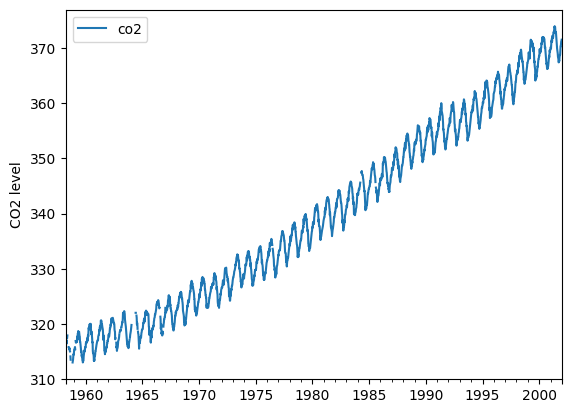

In [5]:
import matplotlib.pyplot as plt
ax = data.plot()
ax.set_ylabel('CO2 level')
plt.show()

**Esecuzione del modello (parametri scelti da cross validazione)**

In [ ]:
from pyspark.sql.types import *
from prophet import Prophet
from prophet.make_holidays import make_holidays_df


yearly_seasonality = unique_id_pd['yearly_seasonality'].iloc[0]
yearly_seasonality_fourier_order = unique_id_pd['yearly_seasonality_fourier_order'].iloc[0]
changepoint_prior_scale = unique_id_pd['changepoint_prior_scale'].iloc[0]
seasonality_prior_scale = unique_id_pd['seasonality_prior_scale'].iloc[0]
seasonality_mode = unique_id_pd['seasonality_mode'].iloc[0]
forecast_horizon = unique_id_pd['forecast_horizon'].iloc[0]
weekly_seasonality_fourier_order = unique_id_pd['weekly_seasonality_fourier_order'].iloc[0]

model = Prophet(
        #interval_width=0.85
     # ,
        yearly_seasonality= yearly_seasonality_fourier_order
      , weekly_seasonality=weekly_seasonality_fourier_order
      , changepoint_prior_scale = changepoint_prior_scale
      , seasonality_prior_scale = seasonality_prior_scale
      ,  seasonality_mode = seasonality_mode)

model.add_country_holidays(country_name='IT')

#model.add_seasonality(name='year', period=12, fourier_order = 10)
model.fit( unique_id_pd )

future_pd = model.make_future_dataframe(
periods=forecast_horizon,
freq='D',
include_history=True
)

forecast_pd = model.predict( future_pd )

f_pd = forecast_pd.set_index('ds')


fig = model.plot(forecast_pd, xlabel='ds',
ylabel=r'yhat')

fig2 = model.plot_components(forecast_pd)
fig2.show()

print()

**Creazione vista temporanea sui risultati**

**Memorizzazione dati**

In [ ]:
# Comando SQL per selezionare il training set
sql = 'select * from training_table_numero_spedizioni_daily_all_clienti order by unique_id, ds'

# Parizionamento dei dati per la chiave univoca per creare esecuzioni parallele del modello
unique_id_part = (spark.sql( sql ).repartition(spark.sparkContext.defaultParallelism, ['unique_id'])).cache()

In [ ]:

from pyspark.sql.types import *
from prophet import Prophet
from prophet.make_holidays import make_holidays_df

result_schema =StructType([
  StructField('ds',TimestampType()),
  StructField('unique_id',IntegerType()),
  #StructField('y',DoubleType()),
  StructField('yhat',DoubleType()),
  StructField('yhat_upper',DoubleType()),
  StructField('yhat_lower',DoubleType())
  ])


# Creazione udf in modo che viene eseguita in parallelo per ogni serie

from pyspark.sql.functions import pandas_udf, PandasUDFType

@pandas_udf( result_schema, PandasUDFType.GROUPED_MAP )
def forecast_sales( unique_id_pd ):

  it_holidays = make_holidays_df(
    year_list=[2021 + i for i in range(5)], country='IT'
  )

  yearly_seasonality = unique_id_pd['yearly_seasonality'].iloc[0]
  yearly_seasonality_fourier_order = unique_id_pd['yearly_seasonality_fourier_order'].iloc[0]
  changepoint_prior_scale = unique_id_pd['changepoint_prior_scale'].iloc[0]
  seasonality_prior_scale = unique_id_pd['seasonality_prior_scale'].iloc[0]
  seasonality_mode = unique_id_pd['seasonality_mode'].iloc[0]
  forecast_horizon = unique_id_pd['forecast_horizon'].iloc[0]
  weekly_seasonality_fourier_order = unique_id_pd['weekly_seasonality_fourier_order'].iloc[0]

  model = Prophet(
        interval_width=0.85
      , yearly_seasonality= yearly_seasonality_fourier_order
      , weekly_seasonality=weekly_seasonality_fourier_order
      , changepoint_prior_scale = changepoint_prior_scale
      , seasonality_prior_scale = seasonality_prior_scale
      ,  seasonality_mode = seasonality_mode)

  #if yearly_seasonality:
    #model.add_seasonality(name='yearly', period=7 * 52, fourier_order = 10)

  model.add_country_holidays(country_name='IT')


  model.fit( unique_id_pd )

  future_pd = model.make_future_dataframe(
    periods=forecast_horizon,
    freq='D',
    include_history=False
    )

  forecast_pd = model.predict( future_pd )

  f_pd = forecast_pd[ ['ds','yhat', 'yhat_upper', 'yhat_lower'] ].set_index('ds')

  #st_pd = unique_id_pd[['ds','unique_id']].set_index('ds')

  #results_pd = f_pd.join( st_pd, how='left' )
  results_pd = f_pd
  results_pd.reset_index(level=0, inplace=True)

  results_pd['unique_id'] = unique_id_pd['unique_id'].iloc[0]

  return results_pd[ ['ds', 'unique_id', 'yhat', 'yhat_upper', 'yhat_lower'] ]


# forecasting
results = (
unique_id_part
.groupBy('unique_id')
.apply(forecast_sales))



In [ ]:

results.cache()

results.createOrReplaceTempView("modello_forecast_spedizioni_numero_spedizioni_daily_all_clienti")


**Popolamento tabella di output**

In [ ]:

%%spark
import org.apache.spark.sql.SqlAnalyticsConnector._
import com.microsoft.spark.sqlanalytics.utils.Constants

//val sql_pool_name = "bi-we-prd1-synws.sql.azuresynapse.net"
val sql_pool_name = mssparkutils.env.getWorkspaceName()+".sql.azuresynapse.net"
val db_name = "bi_we_prd1_synws_sqlpool"
val schema_name = "ml"
val table_name = "fact_modello_forecast_spedizioni_numero_spedizioni_daily_all_clienti_stg"

// Scrittura nel SQL pool
spark.sqlContext.sql("SELECT ds, cast(unique_id as int) as unique_id, cast(yhat as float) as y, cast(yhat_upper as float) as y_upper, cast(yhat_lower as float) as y_lower FROM modello_forecast_spedizioni_numero_spedizioni_daily_all_clienti").write.mode("overwrite").option(Constants.SERVER,s"$sql_pool_name").synapsesql(s"$db_name.$schema_name.$table_name" , Constants.INTERNAL)
